# Analysis of CiDiff


## Imports and configuration

In [201]:
import numpy as np
import pandas as pd
import plotnine as pn
import mizani as mi
import mizani.transforms as tr
import statsmodels as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pn.theme_set(pn.theme_minimal())

print("Numpy: %s"%np.__version__)
print("Pandas: %s"%pd.__version__)
print("Plotnine: %s"%pn.__version__)
print("Mizani: %s"%mi.__version__)
print("statsmodels: %s"%sm.__version__)

Numpy: 2.2.2
Pandas: 2.2.3
Plotnine: 0.14.5
Mizani: 0.13.1
statsmodels: 0.14.4


In [202]:
def order(df, col):
    l = df[col].value_counts().index.to_list()
    l.reverse()
    c = pd.Categorical(df[col], categories=l)
    df[col] = c
    return df

In [203]:
DATASET_FILE = "./dataset.csv"
BENCHMARK_FILE = "./benchmark-slayer.csv"
SURVEY_FILE = "./survey.csv"
ANNOTATIONS_FILE = "./results.csv"

## Dataset Analysis

In [204]:
dataset = pd.read_csv(DATASET_FILE, sep=',')
dataset["total_size"] = dataset["success"] + dataset["failure"]
lines_bins = [0, 100, 1000, 10000, 100000, float('inf')]
lines_labels = ['0-100', '100-1K', '1K-10K', '10K-100K', '100K+']
dataset['line_bins'] = pd.cut(dataset['total_size'], bins=lines_bins, labels=lines_labels, right=False, include_lowest=True)

dataset.head()

,repository,run,language,success,failure,total_size,line_bins
0,stimulusreflex/cable_ready,run456-0,Ruby,585,603,1188,1K-10K
1,stimulusreflex/cable_ready,run740-0,Ruby,579,498,1077,1K-10K
2,yogeshojha/rengine,run1445-0,JavaScript,62,67,129,100-1K
3,marcominerva/chatgptnet,run35-0,C#,740,750,1490,1K-10K
4,determinatesystems/nix-installer,run1008-0,Rust,929,550,1479,1K-10K


In [205]:
print(len(dataset))
print(len(set(dataset["repository"].to_list())))
print(len(set(dataset["language"].to_list())))

17906
7955
20


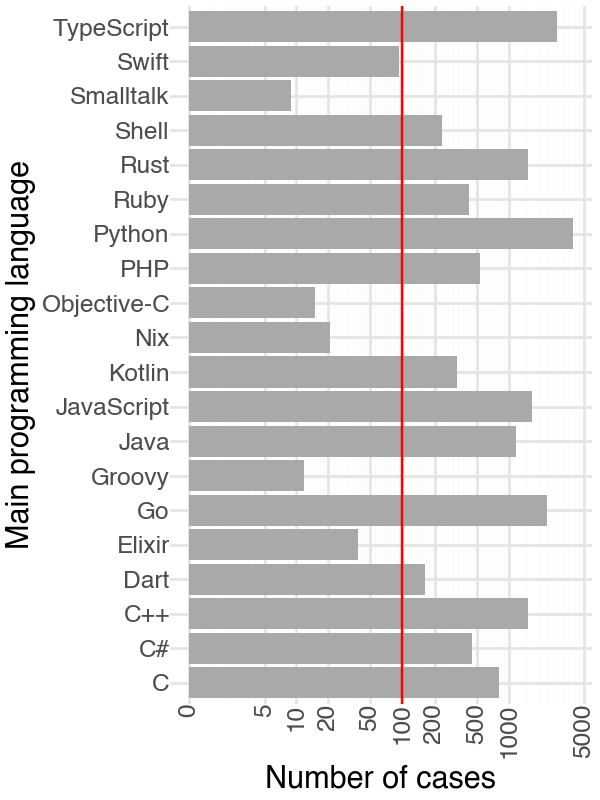

In [206]:
plot = pn.ggplot(dataset, pn.aes(x="language")) + pn.geom_bar(fill="darkgrey") + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 5, 10, 20, 50, 100, 200, 500, 1000, 5000]) + pn.xlab("Main programming language") + pn.ylab("Number of cases") + pn.geom_hline(yintercept=100, color="red") + pn.coord_flip() + pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(3, 4))
plot.save("img/main_language_per_case.pdf", verbose=False)
plot


In [207]:
dataset["language"].value_counts().to_frame()

,count
language,
Python,3930
TypeScript,2782
Go,2271
JavaScript,1653
Rust,1514
C++,1495
Java,1149
C,807
PHP,528


In [208]:
len(set(dataset["repository"].to_list()))

7955

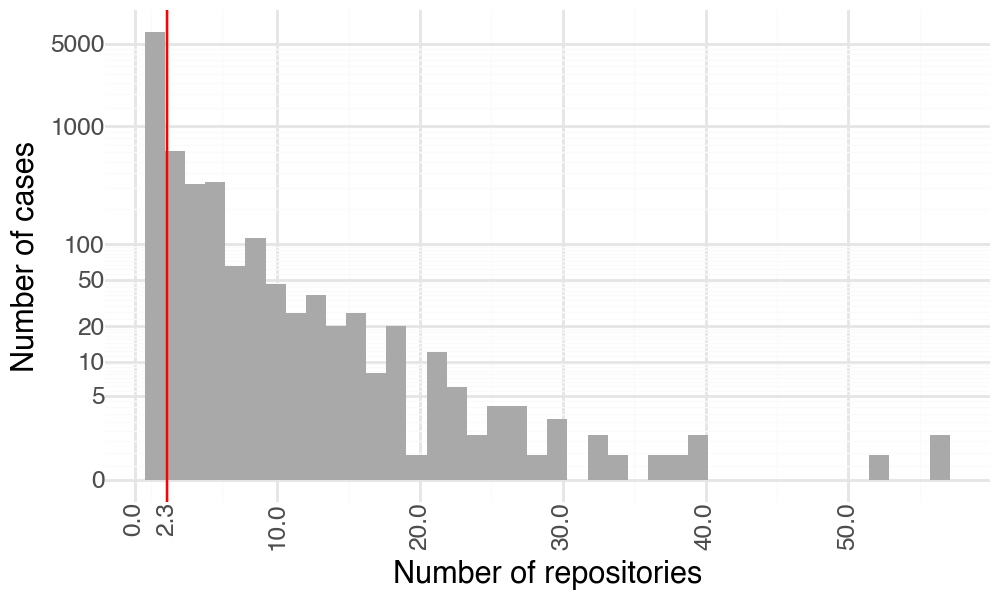

In [209]:
projects = dataset["repository"].value_counts().to_frame()
plot = pn.ggplot(projects, pn.aes(x="count")) + pn.geom_histogram(bins=40, fill="darkgrey") + pn.geom_vline(xintercept=projects["count"].mean(), color="red") + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 5, 10, 20,50, 100, 1000, 5000]) + pn.ylab("Number of cases") + pn.scale_x_continuous(breaks=[0, projects["count"].mean(), 10, 20, 30, 40, 50, 60]) +  pn.xlab("Number of repositories") + pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(5, 3))
plot.save("img/cases_per_project.pdf", verbose=False)
plot

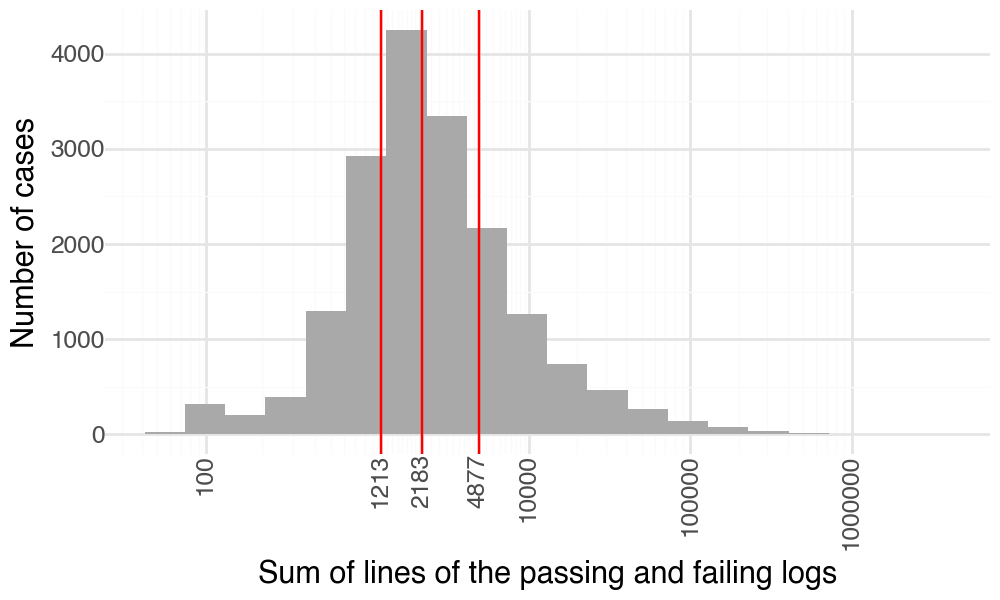

In [210]:
plot = pn.ggplot(dataset, pn.aes(x="total_size")) + pn.geom_histogram(bins=20, fill="darkgrey") + pn.scale_x_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0,1,10,100,dataset["total_size"].quantile(0.25),dataset["total_size"].quantile(0.5),dataset["total_size"].quantile(0.75),10000,100000,1000000]) + pn.geom_vline(xintercept=dataset["total_size"].quantile(0.5), color="red") + pn.geom_vline(xintercept=dataset["total_size"].quantile(0.25), color="red") + pn.geom_vline(xintercept=dataset["total_size"].quantile(0.75), color="red") + pn.ylab("Number of cases") + pn.xlab("Sum of lines of the passing and failing logs") + pn.theme(axis_text_x = pn.element_text(angle = 90), figure_size=(5,3))
plot.save("img/total_lines_per_case.pdf", verbose=False)
plot

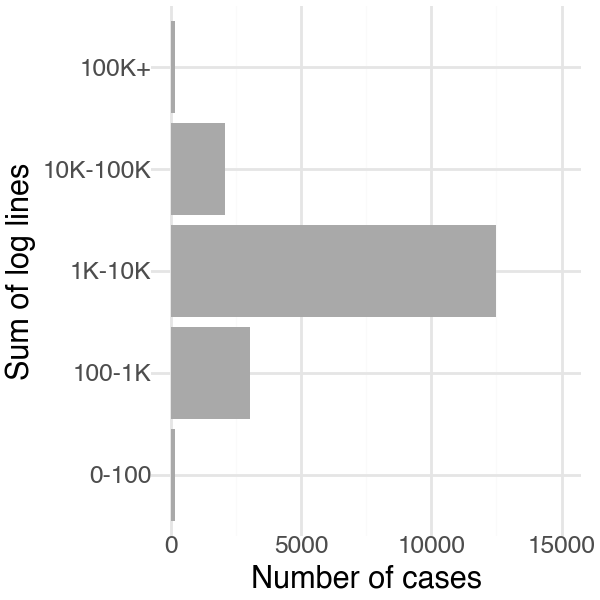

In [211]:
pn.ggplot(dataset, pn.aes(x="line_bins")) + pn.geom_bar(fill="darkgrey") + pn.xlab("Sum of log lines") + pn.ylim(0,15000) + pn.ylab("Number of cases") + pn.coord_flip() + pn.theme(figure_size=(3, 3))

## Benchmark Results Analysis

In [212]:
data = pd.read_csv(BENCHMARK_FILE, sep=',')
data.head()

,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,runs
0,freecodecamp/freecodecamp/run608-0,seed,2.1,67,68,2,1,0,1,0,0,8,3,5,5
1,freecodecamp/freecodecamp/run608-0,lcs,1.6,67,68,3,2,1,0,0,0,8,3,5,5
2,freecodecamp/freecodecamp/run41367-0,seed,14.0,1022,1045,191,34,11,126,20,0,141,71,70,5
3,freecodecamp/freecodecamp/run41367-0,lcs,4.6,1022,1045,337,180,157,0,0,0,136,69,67,5
4,freecodecamp/mobile/run3037-0,seed,7.1,1170,1082,158,14,102,41,1,0,138,76,62,5


In [213]:
REFERENCE_TYPE = "lcs"
ALTERNATE_TYPES = ["seed"]
REFERENCE_SUFFIX = "-" + REFERENCE_TYPE

In [214]:
data[data["duration"] == -1.0].groupby("type").count()["duration"].to_frame()

,duration
type,
lcs,28
seed,23


In [215]:
print(set(data[data["duration"] == -1.0][data["type"] == "lcs"]["directory"].to_list()) - set(data[data["duration"] == -1.0][data["type"] == "seed"]["directory"].to_list()))
print(set(data[data["duration"] == -1.0][data["type"] == "seed"]["directory"].to_list()) - set(data[data["duration"] == -1.0][data["type"] == "lcs"]["directory"].to_list()))

{'cassandre-tech/cassandre-trading-bot/run798-0', 'apache/helix/run2672-0', 'freeradius/freeradius-server/run3529-0', 'freeradius/freeradius-server/run3532-0', 'apache/tika/run117-0'}
set()


/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_54962/1200980711.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_54962/1200980711.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_54962/1200980711.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_54962/1200980711.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [216]:
duration_bins = [-1.0, 0.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, float('inf')]
data['duration-bin'] = pd.cut(data['duration'], bins=duration_bins, labels=["timeout", "0-10ms", "10-100ms", "100-1000ms", "1000-10000ms", "10000-100000ms", ">=100000ms"], include_lowest=True)
data['duration-bin'].value_counts().to_frame()

,count
duration-bin,
0-10ms,15579
10-100ms,14325
100-1000ms,3666
1000-10000ms,1425
10000-100000ms,594
>=100000ms,172
timeout,51


In [217]:
timeouts = set(data[data["duration"] == -1.0]["directory"].to_list())
paired_data = data[~data["directory"].isin(timeouts)]

ref_data = paired_data[paired_data["type"] == REFERENCE_TYPE][["directory", "duration", "actions", "added"]]
print(len(ref_data))

variant_data = paired_data[paired_data["type"].isin(ALTERNATE_TYPES)]
merged_data = variant_data.merge(ref_data, left_on="directory", right_on="directory", how="left", suffixes=["", REFERENCE_SUFFIX])

merged_data["duration-diff"] = 100 * (merged_data["duration"] - merged_data["duration" + REFERENCE_SUFFIX]) / (merged_data["duration" + REFERENCE_SUFFIX] + 1)

merged_data["duration-absdiff"] = merged_data["duration"] - merged_data["duration-lcs"]
                                                                        
merged_data["actions-diff"] = 100 * (merged_data["actions"] - merged_data["actions" + REFERENCE_SUFFIX]) / (merged_data["actions" + REFERENCE_SUFFIX] + 1)

merged_data["added-diff"] = 100 * (merged_data["added"] - merged_data["added" + REFERENCE_SUFFIX]) / (merged_data["added" + REFERENCE_SUFFIX] + 1) 

merged_data["lines-all"] = merged_data["lines-left"] + merged_data["lines-right"]

bins = [0, 100, 1000, 10000, 100000, float('inf')]
labels = ['0-100', '100-1K', '1K-10K', '10K-100K', '100K+']
merged_data['lines_all_bins'] = pd.cut(merged_data['lines-all'], bins=bins, labels=labels, right=False)

merged_data.head()


17878


,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,runs,duration-bin,duration-lcs,actions-lcs,added-lcs,duration-diff,duration-absdiff,actions-diff,added-diff,lines-all,lines_all_bins
0,freecodecamp/freecodecamp/run608-0,seed,2.1,67,68,2,1,0,1,0,0,8,3,5,5,0-10ms,1.6,3,2,19.230769,0.5,-25.000000,-33.333333,135,100-1K
1,freecodecamp/freecodecamp/run41367-0,seed,14.0,1022,1045,191,34,11,126,20,0,141,71,70,5,10-100ms,4.6,337,180,167.857143,9.4,-43.195266,-80.662983,2067,1K-10K
2,freecodecamp/mobile/run3037-0,seed,7.1,1170,1082,158,14,102,41,1,0,138,76,62,5,0-10ms,9.1,200,56,-19.801980,-2.0,-20.895522,-73.684211,2252,1K-10K
3,freecodecamp/developer_quiz_site/run1951-0,seed,3.3,457,468,36,17,6,13,0,0,58,29,29,5,0-10ms,2.9,49,30,10.256410,0.4,-26.000000,-41.935484,925,100-1K
4,freecodecamp/news-translation/run386-0,seed,10.1,501,456,368,4,49,315,0,0,38,19,19,5,10-100ms,6.0,683,319,58.571429,4.1,-46.052632,-98.437500,957,100-1K


In [218]:
merged_data.groupby("type")[["actions-diff","added-diff", "duration-diff"]].median()

,actions-diff,added-diff,duration-diff
type,,,
seed,-20.720721,-60.056604,-1.315789


/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 2 x 4 in image.
/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: img/actions_diff.pdf


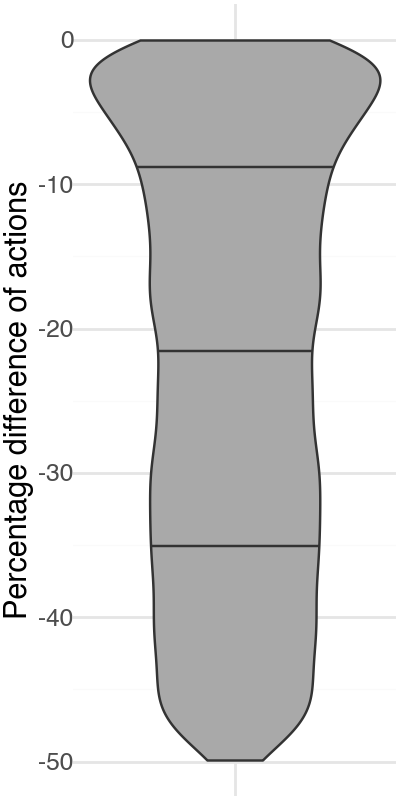

In [219]:
plot = pn.ggplot(merged_data, pn.aes(x="type", y="actions-diff")) + pn.geom_violin(fill="darkgrey", draw_quantiles=[0.25,0.5,0.75]) + pn.ylab("Percentage difference of actions") + pn.xlab("") + pn.theme(axis_text_x=pn.element_blank(), figure_size=(2,4))
plot.save("img/actions_diff.pdf")
plot

/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: img/actions_diff_binned.pdf


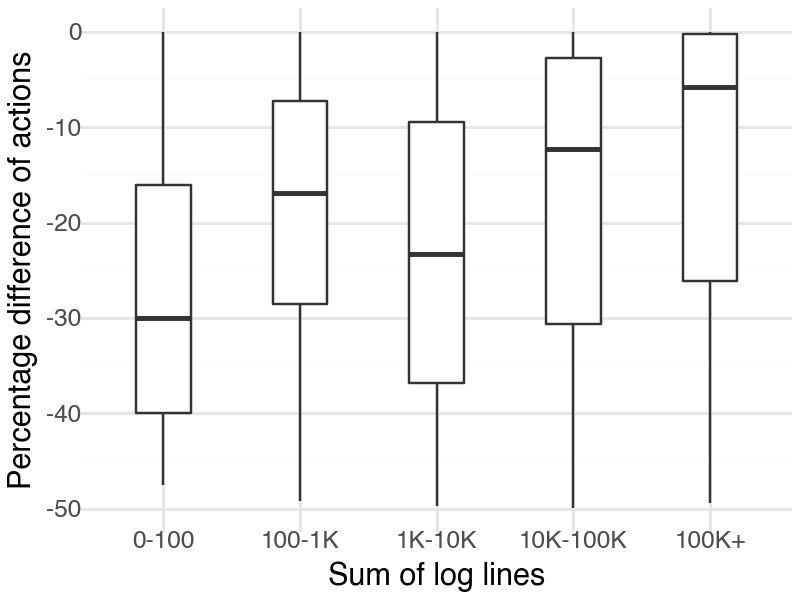

In [220]:
plot = pn.ggplot(merged_data, pn.aes(x='lines_all_bins', y='actions-diff')) + pn.geom_boxplot(width=0.4) + pn.theme_minimal() + pn.xlab("Sum of log lines") + pn.ylab("Percentage difference of actions") + pn.theme(figure_size=(4,3))
plot.save("img/actions_diff_binned.pdf")
plot

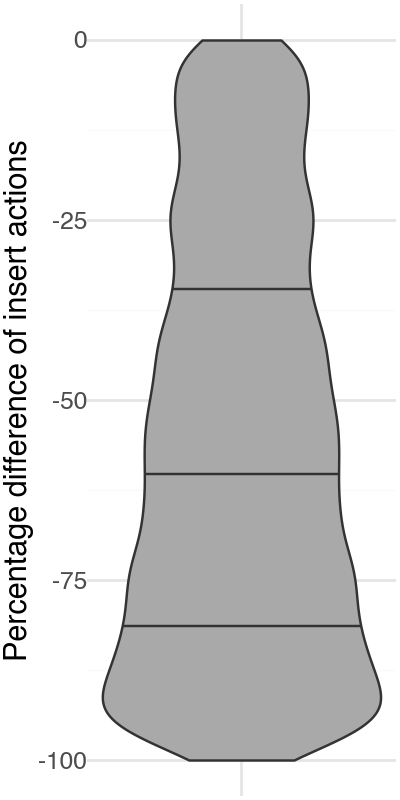

In [221]:
plot = pn.ggplot(merged_data, pn.aes(x="type", y="added-diff")) + pn.geom_violin(fill="darkgrey", draw_quantiles=[0.25,0.5,0.75]) + pn.ylab("Percentage difference of insert actions") + pn.xlab("") + pn.theme(axis_text_x=pn.element_blank(), figure_size=(2, 4))
plot.save("img/added_diff.pdf", verbose=False)
plot

/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: img/added_diff_binned.pdf


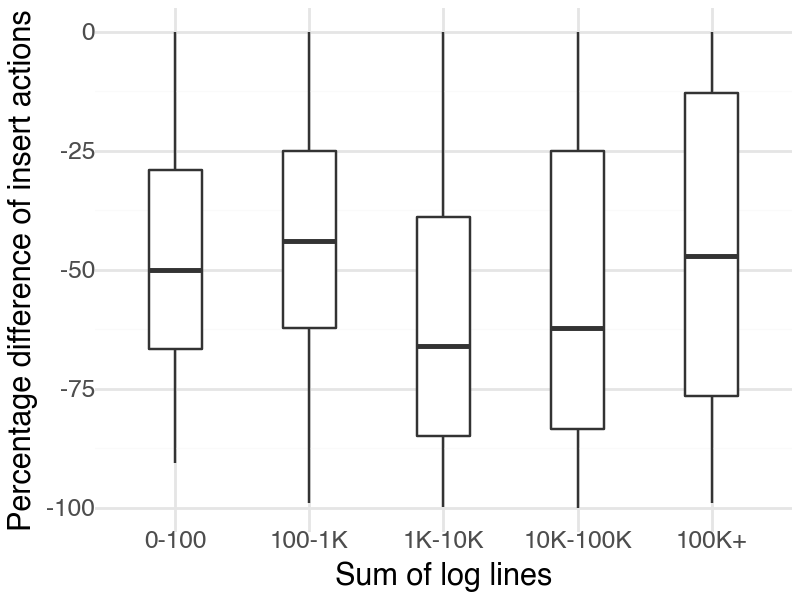

In [222]:
plot = pn.ggplot(merged_data, pn.aes(x='lines_all_bins', y='added-diff')) + pn.geom_boxplot(width=0.4) + pn.theme_minimal() + pn.xlab("Sum of log lines") + pn.ylab("Percentage difference of insert actions") + pn.theme(figure_size=(4,3))
plot.save("img/added_diff_binned.pdf")
plot

/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 2 x 4 in image.
/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: img/runtime_diff.pdf


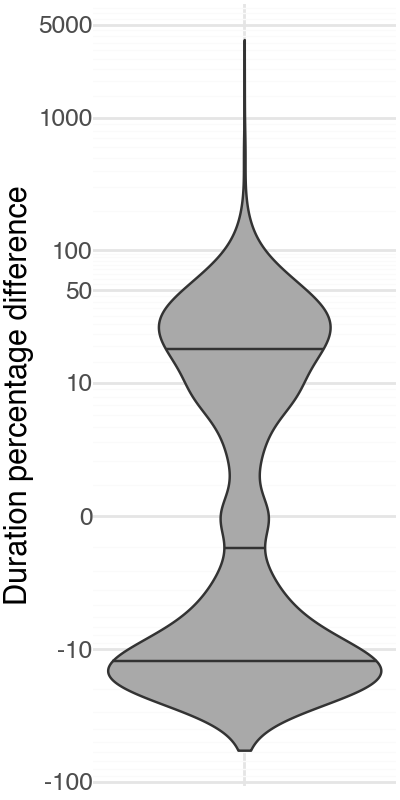

In [223]:
plot = pn.ggplot(merged_data, pn.aes(x="type", y="duration-diff")) + pn.geom_violin(fill="darkgrey", draw_quantiles=[0.25,0.5,0.75]) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[-100, -10, 0, 10, 50, 100, 1000, 5000, 10000]) + pn.ylab("Duration percentage difference") + pn.xlab("") + pn.theme(axis_text_x=pn.element_blank(), figure_size=(2, 4))
plot.save("img/runtime_diff.pdf")
plot

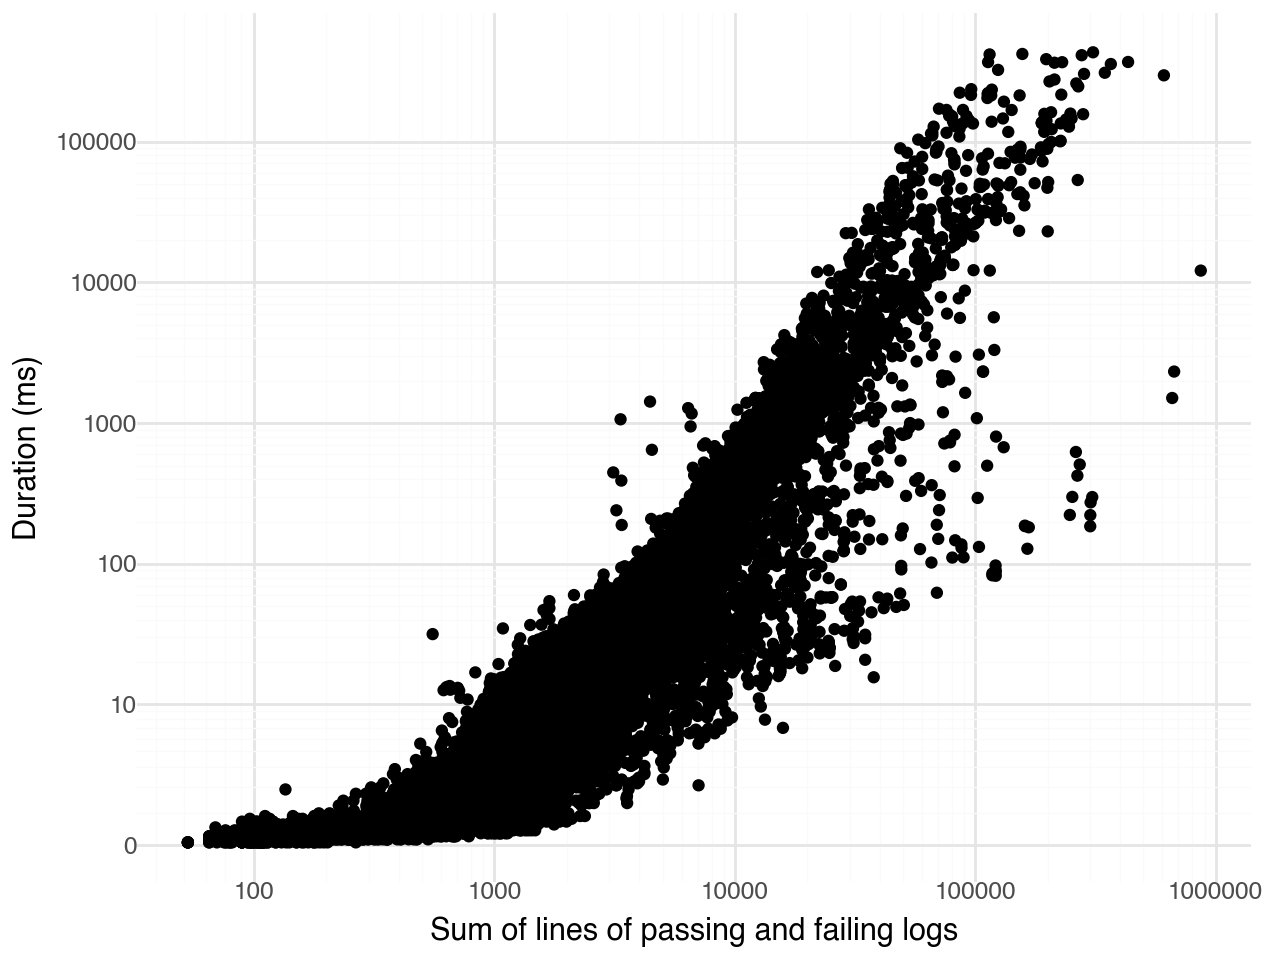

In [224]:
plot = pn.ggplot(merged_data, pn.aes(x="lines-all", y="duration")) + pn.geom_point() + pn.scale_x_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, -10, 100, 1000, 10000, 100000, 1000000]) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[0, 10, 100, 1000, 10000, 100000]) + pn.xlab("Sum of lines of passing and failing logs") + pn.ylab("Duration (ms)")
plot.save("img/runtimes.pdf", verbose=False)
plot

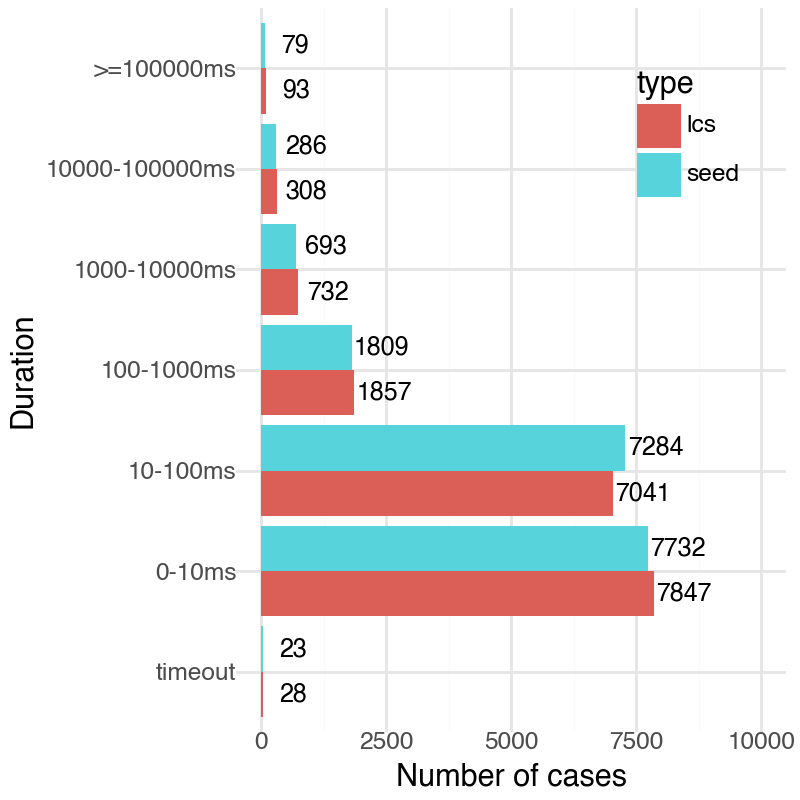

In [225]:
pn.ggplot(data, pn.aes(x="duration-bin", fill="type")) + pn.geom_bar(position="dodge") + pn.geom_text(pn.aes(label=pn.after_stat("count"), y=pn.stage(after_stat="count", after_scale="y + 600")), stat="count", position=pn.position_dodge2(width=0.9), size=9) + pn.scale_x_discrete() + pn.ylim(0, 10000) + pn.coord_flip() + pn.xlab("Duration") + pn.ylab("Number of cases") + pn.theme(figure_size=(4, 4), legend_position=(0.9,0.9))

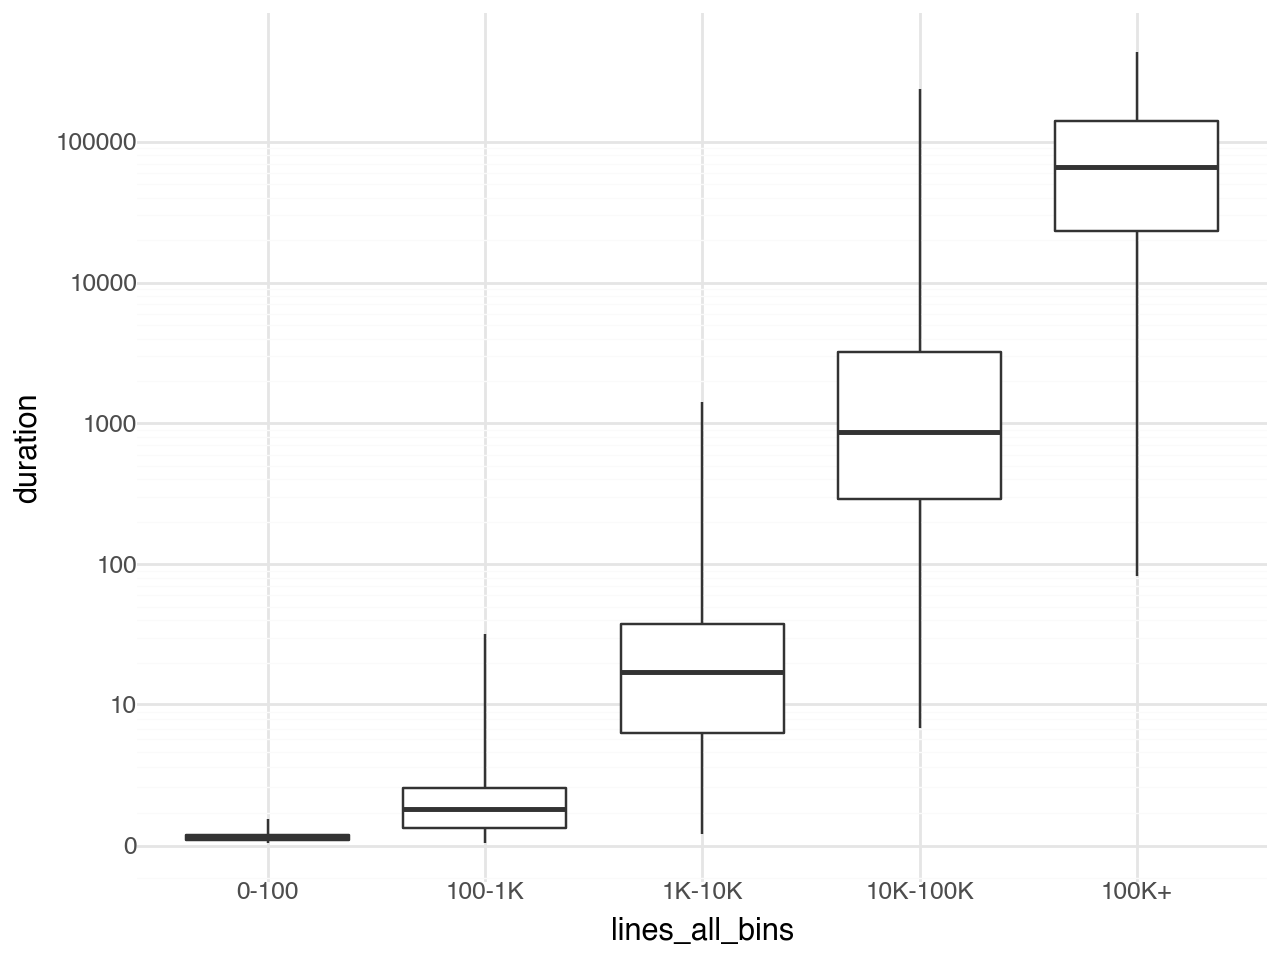

In [226]:
pn.ggplot(merged_data, pn.aes(x='lines_all_bins', y='duration')) + pn.geom_boxplot(coef=1000) + pn.scale_y_continuous(trans=tr.pseudo_log_trans(base=10), breaks=[-10000, -1000, -100, -10, 0, 10, 100, 1000, 10000, 100000]) + pn.theme_minimal()

In [227]:
merged_data[merged_data["duration-absdiff"] > 10000]

,directory,type,duration,lines-left,lines-right,actions,added,deleted,updated,moved-unchanged,moved-updated,similar-groups,similar-groups-left,similar-groups-right,runs,duration-bin,duration-lcs,actions-lcs,added-lcs,duration-diff,duration-absdiff,actions-diff,added-diff,lines-all,lines_all_bins
1822,resteasy/resteasy/run1266-0,seed,123574.2,64529,21533,71418,12703,55699,2569,395,52,4179,2101,2078,5,>=100000ms,95448.9,74434,15719,29.466034,28125.3,-4.051857,-19.185751,86062,10K-100K
5314,huggingface/optimum/run5334-0,seed,222834.5,43108,43093,36893,9018,9033,13399,2557,2886,9622,4849,4773,5,>=100000ms,153636.7,55735,27860,45.039596,69197.8,-33.805799,-67.628585,86201,10K-100K
7839,vearch/vearch/run150-0,seed,385645.4,189269,8024,193326,5695,186940,679,12,0,220,114,106,5,>=100000ms,292752.7,194017,6386,31.730666,92892.7,-0.356153,-10.818851,197293,100K+
8377,nilfoundation/zkllvm/run57-0,seed,35553.7,31635,12102,28160,697,20230,664,439,6130,1917,969,948,5,10000-100000ms,16215.5,35393,7930,119.250146,19338.2,-20.435667,-91.199092,43737,10K-100K
10908,alexandrerouma/sdrplusplus/run1085-0,seed,152864.4,41739,36111,61478,24700,30328,6285,138,27,1532,784,748,5,>=100000ms,116563.0,67928,31150,31.142891,36301.4,-9.495208,-20.705595,77850,10K-100K
14270,bforartists/bforartists/run284-0,seed,155210.2,42355,36122,35471,5664,11897,5945,3531,8434,27105,13703,13402,5,>=100000ms,107840.4,53381,23574,43.925431,47369.8,-33.550635,-75.970308,78477,10K-100K


## Survey Analysis

In [228]:
survey = pd.read_csv(SURVEY_FILE, sep=',')
survey.replace(to_replace={"alpha": "CiDiff", "beta": "LCS-diff", "apha": "CiDiff", "none": "None"}, inplace=True)
survey.head()

,id,side-by-side,summary,p1,p2,p3
0,bytedeco/javacpp-presets/run46-1,diff 0,None,None,None,None
1,netlify/netlify-plugin-nextjs/run4250-0,diff 1,None,None,None,CiDiff
2,python-markdown/markdown/run641-7,diff 2,None,None,None,None
3,ufbx/ufbx/run1143-4,diff 3,CiDiff,CiDiff,None,CiDiff
4,eliaskosunen/scnlib/run307-3,diff 4,None,None,None,None


In [229]:
ratios = pd.DataFrame({"p": survey["summary"].value_counts() / len(survey)}).reset_index()
ratios["p_min"] = np.maximum(ratios["p"] - 0.10, 0)
ratios["p_max"] = np.minimum(ratios["p"] + 0.10, 1)

ratios

,summary,p,p_min,p_max
0,CiDiff,0.70,0.60,0.80
1,None,0.25,0.15,0.35
2,LCS-diff,0.05,0.00,0.15


/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 2 in image.
/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: img/survey.pdf


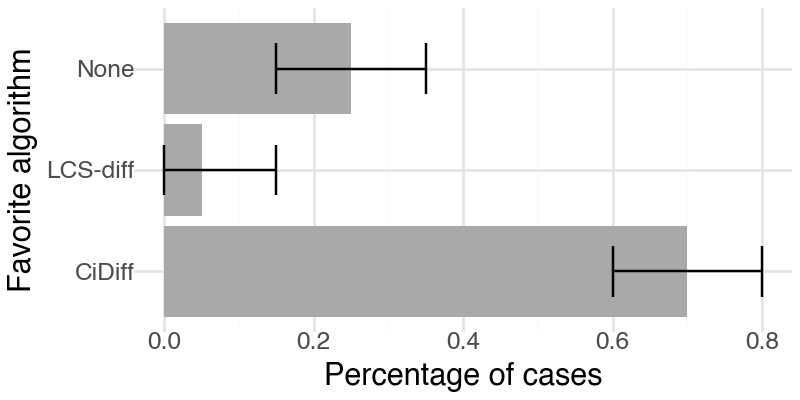

In [230]:
plot = pn.ggplot(ratios, pn.aes(x="summary", y="p")) + pn.geom_bar(stat="identity", fill="darkgrey") + pn.geom_errorbar(pn.aes(ymin="p_min", ymax="p_max")) + pn.ylab("Percentage of cases") + pn.xlab("Favorite algorithm") + pn.coord_flip() + pn.theme(figure_size=(4, 2))
plot.save("img/survey.pdf") 
plot

In [231]:
ratings = survey[["p1", "p2", "p3"]]
ratings["none"] = (ratings[["p1", "p2", "p3"]] == "None").sum(axis=1)
ratings["cidiff"] = (ratings[["p1", "p2", "p3"]] == "CiDiff").sum(axis=1)
ratings["lcs"] = (ratings[["p1", "p2", "p3"]] == "LCS-diff").sum(axis=1)

final_ratings = ratings[["none", "cidiff", "lcs"]]

sm.stats.inter_rater.fleiss_kappa(final_ratings, method="fleiss")

/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_54962/793957973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/n_/dlsgjw2d6g96px8dr37bp7jc0000gn/T/ipykernel_54962/793957973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


np.float64(0.24551386623164734)

In [232]:
survey[survey["summary"] == "LCS-diff"]

,id,side-by-side,summary,p1,p2,p3
72,kreneskyp/ix/run573-0,diff 72,LCS-diff,CiDiff,LCS-diff,LCS-diff
75,apollographql/apollo-client-nextjs/run24-0,diff 75,LCS-diff,CiDiff,LCS-diff,LCS-diff
82,npm/ini/run266-17,diff 82,LCS-diff,CiDiff,LCS-diff,LCS-diff
84,flathunters/flathunter/run634-0,diff 84,LCS-diff,CiDiff,LCS-diff,LCS-diff
89,mohsenabrishami/stethoscope/run554-0,diff 89,LCS-diff,CiDiff,LCS-diff,LCS-diff


## Accuracy analysis

In [238]:
def precs_and_recs(data, ref, algorithms):
    grouped = data.groupby(["path","type"])["line"].apply(set)
    values = []
    for path in set([path for (path, _) in grouped.keys()]):
        ref_lines = grouped[path][ref]
        for alg in algorithms:
            if grouped[path].get(alg) is None:
                values.append([path, alg, 0.0, 0.0])
                continue

            alg_lines = grouped[path][alg]
            common_lines = ref_lines & alg_lines
            recall = len(common_lines) / len(ref_lines)
            precision = len(common_lines) / len(alg_lines)
            values.append([path, alg, precision, recall])

    return pd.DataFrame(values, columns=['path', 'algorithm', 'precision', 'recall'])

In [239]:
accuracies = precs_and_recs(pd.read_csv(ANNOTATIONS_FILE), 'human', ['bigram', 'lcs', 'seed', 'keyword'])
accuracies['f1-score'] = 2 * ((accuracies['precision'] * accuracies['recall']) / (accuracies['precision'] + accuracies['recall']))
legends = ['2kdiff (bigram)', 'keyword', 'lcs-diff', 'cidiff']
accuracies.head()

,path,algorithm,precision,recall,f1-score
0,ogen-go/ogen/run3474-3,bigram,0.114286,1.000000,0.205128
1,ogen-go/ogen/run3474-3,lcs,0.184615,1.000000,0.311688
2,ogen-go/ogen/run3474-3,seed,0.324324,1.000000,0.489796
3,ogen-go/ogen/run3474-3,keyword,0.666667,0.666667,0.666667
4,doocs/leetcode/run105-0,bigram,0.047619,1.000000,0.090909


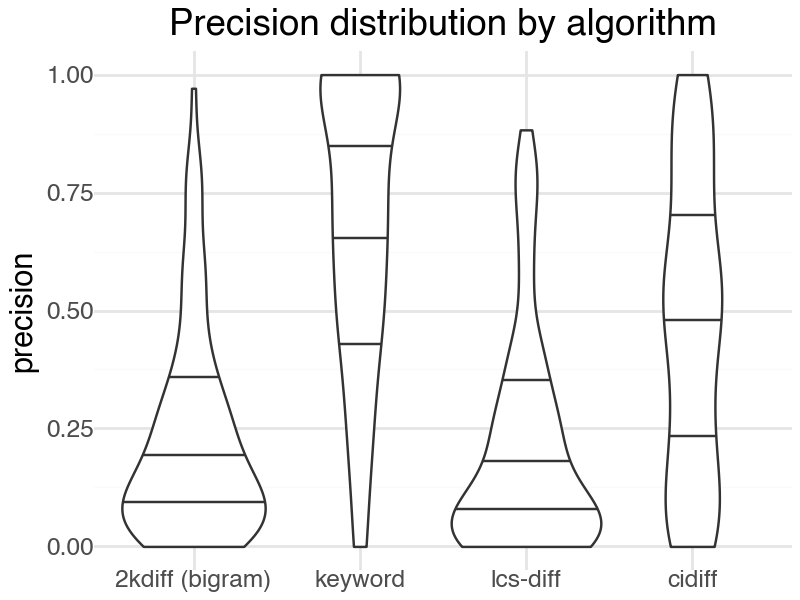

In [240]:
plot = pn.ggplot(accuracies, pn.aes(x='algorithm', y='precision')) + pn.geom_violin(scale="count", draw_quantiles=[0.25, 0.5, 0.75]) + pn.scale_x_discrete(labels=legends) + pn.xlab('') + pn.ggtitle("Precision distribution by algorithm") + pn.theme(figure_size=(4,3))
plot.save('img/precisions.pdf', verbose=False)
plot

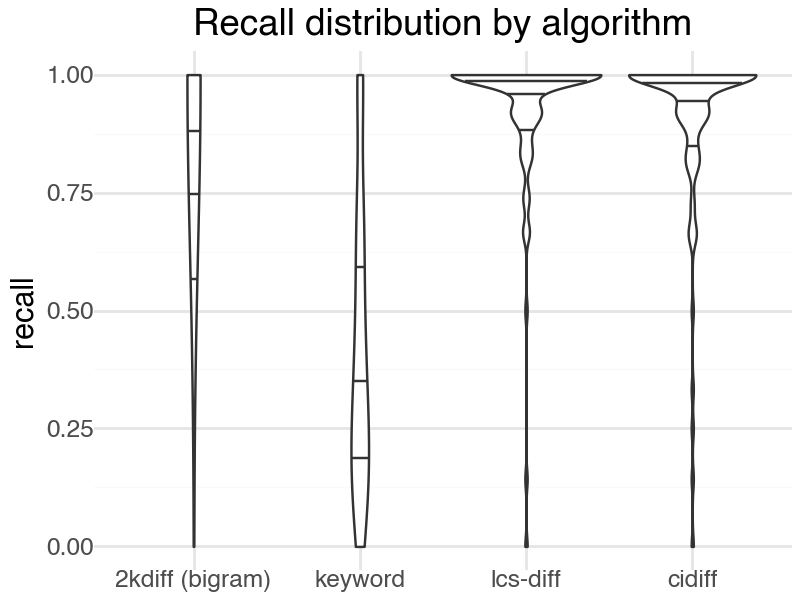

In [241]:
plot = pn.ggplot(accuracies, pn.aes(x='algorithm', y='recall')) + pn.geom_violin(scale="area", draw_quantiles=[0.25, 0.5, 0.75]) + pn.scale_x_discrete(labels=legends) + pn.xlab('') + pn.ggtitle("Recall distribution by algorithm") + pn.theme(figure_size=(4,3))
plot.save('img/recalls.pdf', verbose=False)
plot

/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ydensity : Removed 7 rows containing non-finite values.
/Users/falleri/work/code/cidiff-analysis/.venv/lib/python3.13/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ydensity : Removed 7 rows containing non-finite values.


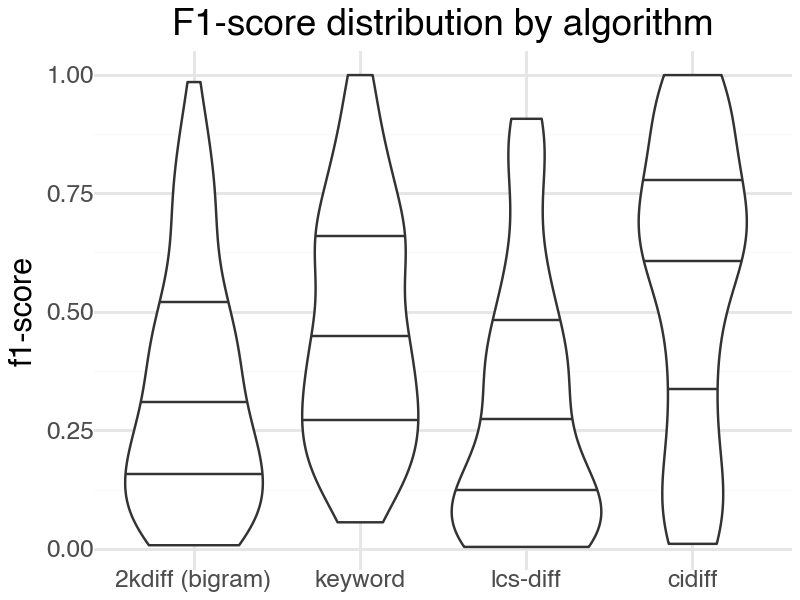

In [242]:
plot = pn.ggplot(accuracies, pn.aes(x='algorithm', y='f1-score')) + pn.geom_violin(scale="area", draw_quantiles=[0.25, 0.5, 0.75]) + pn.scale_x_discrete(labels=legends) + pn.xlab('') + pn.ggtitle("F1-score distribution by algorithm") + pn.theme(figure_size=(4,3))
plot.save('img/f1-scores.pdf', verbose=False)
plot